In [20]:
import os
import subprocess

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import scipy.io
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from torchsummary import summary

import gdown


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def download_dataset(file_ids, download_folder, password):

    os.makedirs(download_folder, exist_ok=True)

    for filename, file_id in file_ids.items():
        file_path = os.path.join(download_folder, filename)
        gdown.download(id=file_id, output=file_path, quiet=False)

    print("Downloaded files: ", os.listdir(download_folder))

    #unzip
    subprocess.run(["7z", "x", f"{download_folder}/sv_data.zip", f"-o{download_folder}/unzipped", f"-p{password}", "-y"], check=True)

    extracted_path = os.path.join(download_folder, "unzipped", "sv_data")
    print("Filed unzip to: ", extracted_path)

    return (extracted_path)


In [3]:
file_ids = {
    "sv_data.z01": "1KK5802tW2fXJN-q9rj2yrJ8hZASItXe_",
    "sv_data.z02": "13s3RUeD4xsC3N2My8YxTkqymEAo_mmdt",
    "sv_data.z03": "1pTaaCSQ7KQxlFyoqwP7DUizbQFuopW_y",
    "sv_data.zip": "1fXAIAusPmSdnaO6IQgwzIp6BNPgTo0kv"
}

download_folder = "/content/archive_parts"
password = "d89551fd190e38"

data_path = download_dataset(file_ids, download_folder, password)

Downloading...
From (original): https://drive.google.com/uc?id=1KK5802tW2fXJN-q9rj2yrJ8hZASItXe_
From (redirected): https://drive.google.com/uc?id=1KK5802tW2fXJN-q9rj2yrJ8hZASItXe_&confirm=t&uuid=8ab85bdf-d8cc-417a-84f9-dfa764900057
To: /content/archive_parts/sv_data.z01
100%|██████████| 734M/734M [00:09<00:00, 77.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=13s3RUeD4xsC3N2My8YxTkqymEAo_mmdt
From (redirected): https://drive.google.com/uc?id=13s3RUeD4xsC3N2My8YxTkqymEAo_mmdt&confirm=t&uuid=3ffa48ea-0f0b-4be7-a4fc-06f36502d730
To: /content/archive_parts/sv_data.z02
100%|██████████| 734M/734M [00:07<00:00, 96.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pTaaCSQ7KQxlFyoqwP7DUizbQFuopW_y
From (redirected): https://drive.google.com/uc?id=1pTaaCSQ7KQxlFyoqwP7DUizbQFuopW_y&confirm=t&uuid=d68da6bc-72bc-4e26-af13-c8c6c5b65086
To: /content/archive_parts/sv_data.z03
100%|██████████| 734M/734M [00:05<00:00, 133MB/s]
Downloading...
From (original): 

Downloaded files:  ['sv_data.z01', 'sv_data.z03', 'sv_data.z02', 'sv_data.zip']
Filed unzip to:  /content/archive_parts/unzipped/sv_data


In [4]:
def load_annotations(data_path):

    model_file = os.path.join(data_path, "sv_make_model_name.mat")
    image_folder = os.path.join(data_path, "image")

    make_model_data = scipy.io.loadmat(model_file)

    data = []
    for surveillance_model_id in range(len(make_model_data["sv_make_model_name"])):
        make = make_model_data["sv_make_model_name"][surveillance_model_id, 0].item()

        model_image_folder = os.path.join(image_folder, str(surveillance_model_id))
        if os.path.exists(model_image_folder):
            for img_name in os.listdir(model_image_folder):
                img_path = os.path.join(str(surveillance_model_id), img_name)
                data.append([img_path, make])

    return pd.DataFrame(data, columns=["image_path", "make"])

In [5]:
df = load_annotations(data_path)

In [6]:
def split_dataset(df, data_path, val_ratio=0.2):
    # Load predefined train/test split files
    train_file = os.path.join(data_path, "train_surveillance.txt")
    test_file = os.path.join(data_path, "test_surveillance.txt")

    with open(train_file, "r") as f:
        train_images = {line.strip() for line in f.readlines()}

    with open(test_file, "r") as f:
        test_images = {line.strip() for line in f.readlines()}

    df["split"] = df["image_path"].apply(lambda x: "train" if x in train_images else ("test" if x in test_images else "other"))

    train_df = df[df["split"] == "train"].copy()
    test_df = df[df["split"] == "test"].copy()
    train_df, val_df = train_test_split(train_df, test_size=val_ratio, stratify=train_df["make"], random_state=42)

    train_df.drop(columns=["split"], inplace=True)
    val_df.drop(columns=["split"], inplace=True)
    test_df.drop(columns=["split"], inplace=True)

    return train_df, val_df, test_df


In [7]:
def encode_labels(train_df, val_df, test_df):
    make_mapping = {name: idx for idx, name in enumerate(train_df["make"].unique())}

    train_df["make_label"] = train_df["make"].map(make_mapping)
    val_df["make_label"] = val_df["make"].map(make_mapping)
    test_df["make_label"] = test_df["make"].map(make_mapping)

    return train_df, val_df, test_df, make_mapping


def calculate_category_counts(train_df, val_df, test_df):

    train_counts = train_df["make"].value_counts().reset_index()
    train_counts.columns = ["make", "num_images_train"]

    val_counts = val_df["make"].value_counts().reset_index()
    val_counts.columns = ["make", "num_images_val"]

    test_counts = test_df["make"].value_counts().reset_index()
    test_counts.columns = ["make", "num_images_test"]

    category_counts = train_counts.merge(val_counts, on="make", how="outer").merge(
        test_counts, on="make", how="outer")

    category_counts.fillna(0, inplace=True)
    category_counts[["num_images_train", "num_images_val", "num_images_test"]] = category_counts[
        ["num_images_train", "num_images_val", "num_images_test"]
    ].astype(int)

    return category_counts


In [8]:
def get_transforms(make, make_counts, threshold=500):

    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
    ]

    if make_counts[make] < threshold:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomRotation(30),
            transforms.RandomAffine(degrees=15, shear=10),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            *base_transforms
        ])
    else:
        return transforms.Compose(base_transforms)


In [9]:
class CompCarsDataset(Dataset):

    def __init__(self, dataframe, root_dir, make_counts, threshold=500):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.make_counts = make_counts
        self.threshold = threshold

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "image/", self.dataframe.iloc[idx]["image_path"])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = Image.fromarray(image)

        make = self.dataframe.iloc[idx]["make"]
        make_label = self.dataframe.iloc[idx]["make_label"]
        make_label = torch.tensor(make_label, dtype=torch.long)

        transform = get_transforms(make, self.make_counts, self.threshold)
        image = transform(image)

        return image, make_label


In [10]:
train_df, val_df, test_df = split_dataset(df, data_path)
train_df, val_df, test_df, make_mapping = encode_labels(train_df, val_df, test_df)

In [11]:
make_counts = train_df["make"].value_counts().to_dict()

train_dataset = CompCarsDataset(train_df, data_path, make_counts, threshold=500)
val_dataset = CompCarsDataset(val_df, data_path, make_counts, threshold=100)
test_dataset = CompCarsDataset(test_df, data_path, make_counts, threshold=100)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_loader)} batches, Val: {len(val_loader)} batches, Test: {len(test_loader)} batches")


Train: 777 batches, Val: 195 batches, Test: 416 batches


In [12]:
class CarMakeResNet(nn.Module):
    def __init__(self, num_classes):
        super(CarMakeResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [13]:
num_classes = len(train_df["make"].unique())

#Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarMakeResNet(num_classes=num_classes).to(device)

print("Classes:", num_classes)
print("Running on:", device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Classes: 67
Running on: cuda


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)  # Get pt = e^(-CE Loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [15]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
path = "/content/drive/My Drive/car_make_resnet18.pth"

model.load_state_dict(torch.load(path))
model.to(device)
model.eval()

<ipython-input-16-f1ecc5fcde8d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


CarMakeResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [17]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the trained model on the test set.
    """
    model.eval()  #Set to evaluation mode
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test
    avg_test_loss = total_test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



In [18]:
#Run evaluation
evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.2078, Test Accuracy: 89.66%


In [21]:
def plot_confusion_matrix(model, test_loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #Plot confusion matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_norm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


In [22]:
def show_misclassified_samples(model, test_loader, class_names, device, num_samples=6):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, true in zip(images, preds, labels):
                if pred != true:
                    misclassified.append((img.cpu(), class_names[pred.item()], class_names[true.item()]))

    #Select random misclassified samples
    random.shuffle(misclassified)
    misclassified = misclassified[:num_samples]

    #Plot images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (img, pred, true) in enumerate(misclassified):
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Pred: {pred}\nTrue: {true}", fontsize=10, color="red")

    plt.show()


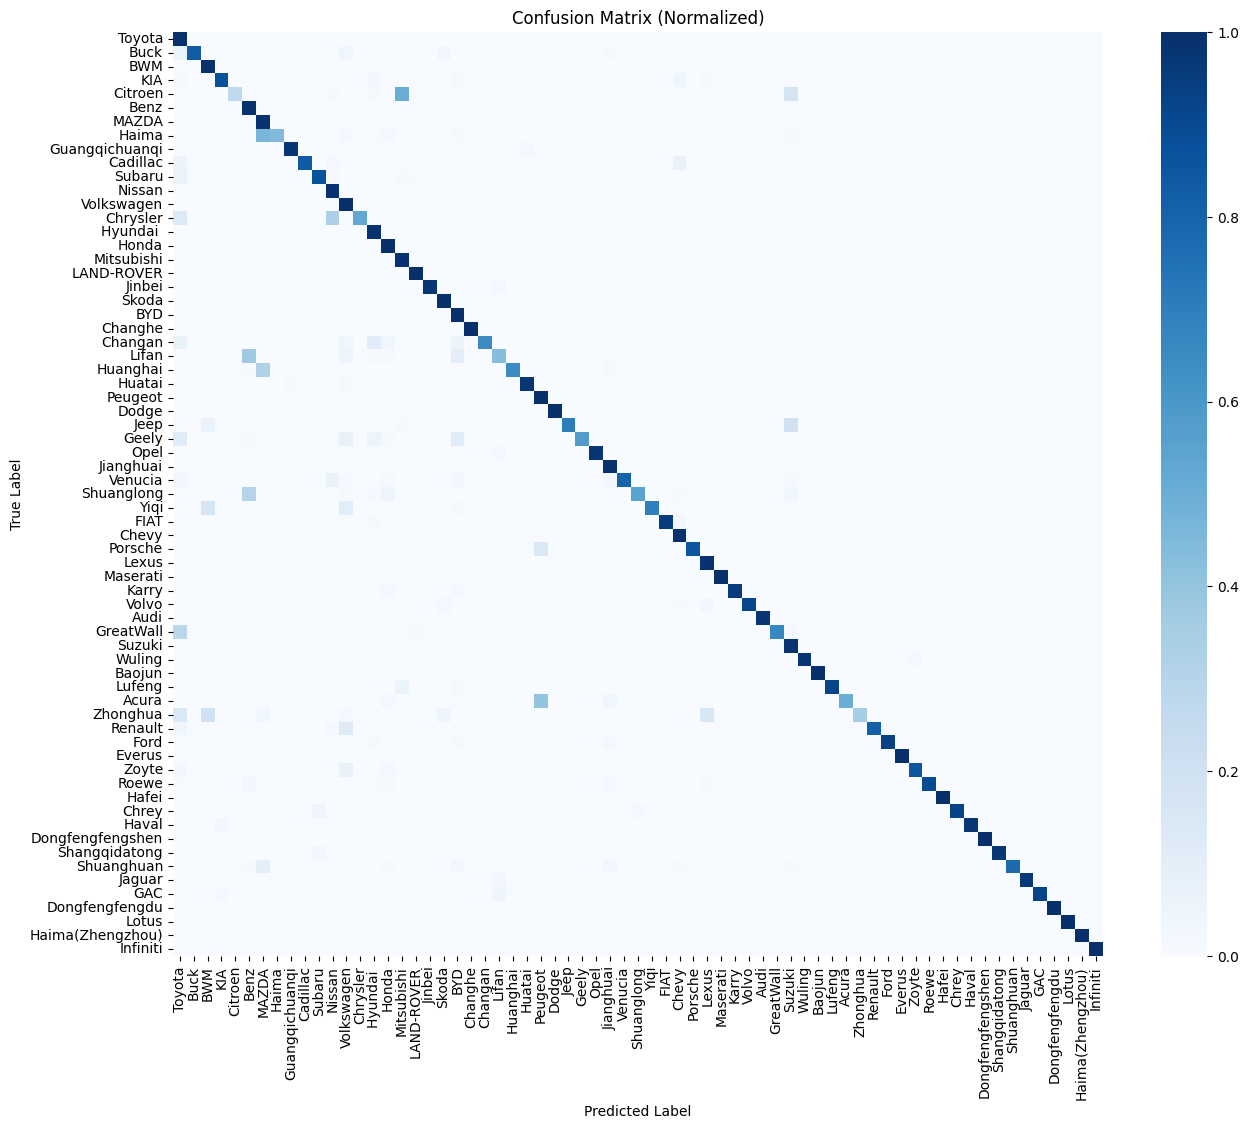

In [23]:
class_names = list(train_df["make"].unique())

plot_confusion_matrix(model, test_loader, class_names, device)

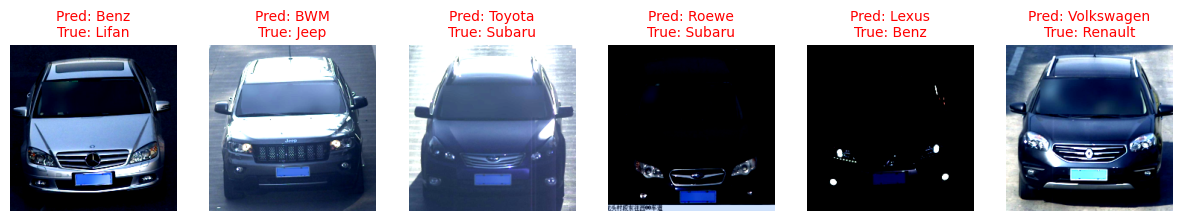

In [24]:
show_misclassified_samples(model, test_loader, class_names, device)